# ring model for SSD in neurons

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.signal import resample
import matplotlib.pyplot as plt
import pandas as pd

from C_module_interface import neuron_gill_ring_sim
from plot_module import plot_ODE

In [5]:
# ode model of SSD in neurons
def neuron_model(t, z):
    so_w, so_m, r1_w, r1_m, r2_w, r2_m, r3_w, r3_m, r4_w, r4_m, r5_w, r5_m, = z
    
    # birth reactions
    birth_soma_wt = 2*MU + C_B*(NSS_S-so_w-so_m*DELTA) 
    birth_soma_mt = 2*MU + C_B*(NSS_S-so_w-so_m*DELTA)
    
    return [so_w*(birth_soma_wt-GAMMA-MU) + r5_w*GAMMA, 
            so_m*(birth_soma_mt-GAMMA-MU) + r5_m*GAMMA, 
            r1_w*(-MU-GAMMA) + so_w*(GAMMA),
            r1_m*(-MU-GAMMA) + so_m*(GAMMA),
            r2_w*(-MU-GAMMA) + r1_w*(GAMMA),
            r2_m*(-MU-GAMMA) + r1_m*(GAMMA),
            r3_w*(-MU-GAMMA) + r2_w*(GAMMA),
            r3_m*(-MU-GAMMA) + r2_m*(GAMMA),
            r4_w*(-MU-GAMMA) + r3_w*(GAMMA),
            r4_m*(-MU-GAMMA) + r3_m*(GAMMA),
            r5_w*(-MU-GAMMA) + r4_w*(GAMMA),
            r5_m*(-MU-GAMMA) + r4_m*(GAMMA),
           ]

### Parameters of the simulation

In [32]:
## BIOLOGICAL PARAMETERS ##
MU = 0.07 # death rate
GAMMA = 0.05 # transport rate
DELTA = 0.5 # mutant deficiency
C_B = 0.1 # birth adaptibility constant
C_T = 0.01 # transport adaptibility constant
NSS_S = 400 # soma population size
NSS_A = 200 # axon population size

## VARIABLE NAMES ##
VARS = ['so wt', 'so mt', 
        'r1 wt', 'r1 mt',
        'r2 wt', 'r2 mt',
        'r3 wt', 'r3 mt',
        'r4 wt', 'r4 mt',
        'r5 wt', 'r5 mt'
       ]

COMP = ['soma','r1','r2','r3','r4','r5',]

## SIMULATION PARAMETERS ##
MAX_T = 500
TIME_POINTS = np.linspace(0, MAX_T, 500)
start_state = np.array([380, 40, 190, 20, 190, 20, 190, 20, 190, 20, 190, 20], dtype = np.int64)

## Deterministic simulation

In [30]:
sol = integrate.solve_ivp(neuron_model, [0, MAX_T], start_state, t_eval=TIME_POINTS, 
                          method = 'LSODA' # eq system is stiff, needs a solver that can handle such cases
                         )

results = sol.y

Final counts:
so wt	380.2	
so mt	40.02	
r1 wt	158.41	
r1 mt	16.68	
r2 wt	66.01	
r2 mt	6.95	
r3 wt	27.5	
r3 mt	2.9	
r4 wt	11.46	
r4 mt	1.21	
r5 wt	4.77	
r5 mt	0.5	

Final effective population size:
soma	400.21	
r1	166.75	
r2	69.48	
r3	28.95	
r4	12.06	
r5	5.03	


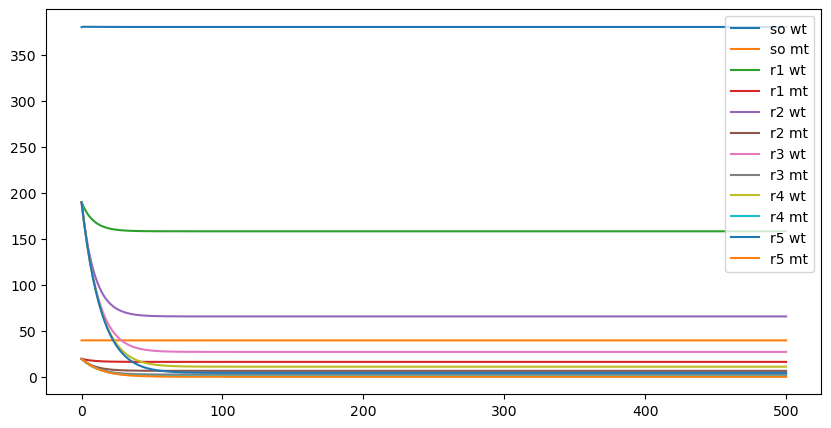

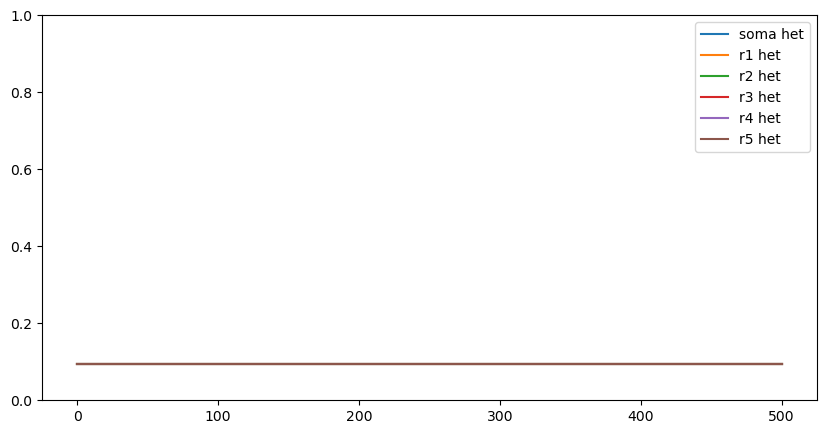

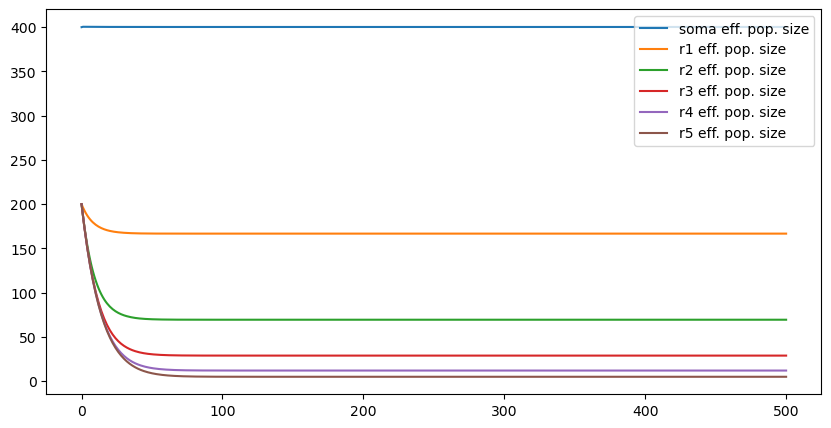

In [36]:
n_var = len(results)
plt.subplots(figsize=(10, 5))
for i in range(n_var):
    plt.plot(TIME_POINTS, results[i], label = VARS[i])
plt.legend()

plt.subplots(figsize=(10, 5))
for i in range(int(n_var/2)):
    het = results[(i*2)+1]/(results[(i*2)+1]+results[i*2])
    plt.plot(TIME_POINTS, het, label = f'{COMP[i]} het')
plt.ylim([0, 1])
plt.legend()

plt.subplots(figsize=(10, 5))
for i in range(int(n_var/2)):
    eps = results[(i*2)+1]*DELTA + results[i*2]
    plt.plot(TIME_POINTS, eps, label = f'{COMP[i]} eff. pop. size')
plt.legend()

print("Final counts:")
for i, res in enumerate(results[:,-1]): print(f'{VARS[i]}\t{round(res,2)}\t')

print("\nFinal effective population size:")
for i in range(int(n_var/2)):
    eps = results[(i*2)+1,-1]*DELTA + results[i*2,-1]
    print(f'{COMP[i]}\t{round(eps, 2)}\t')

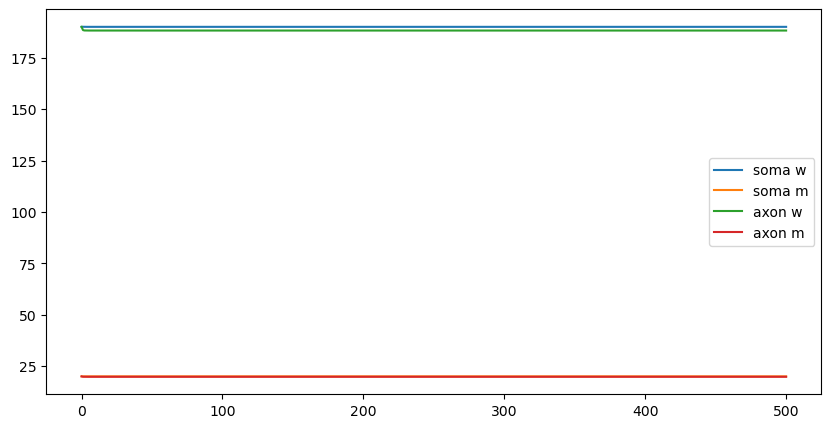

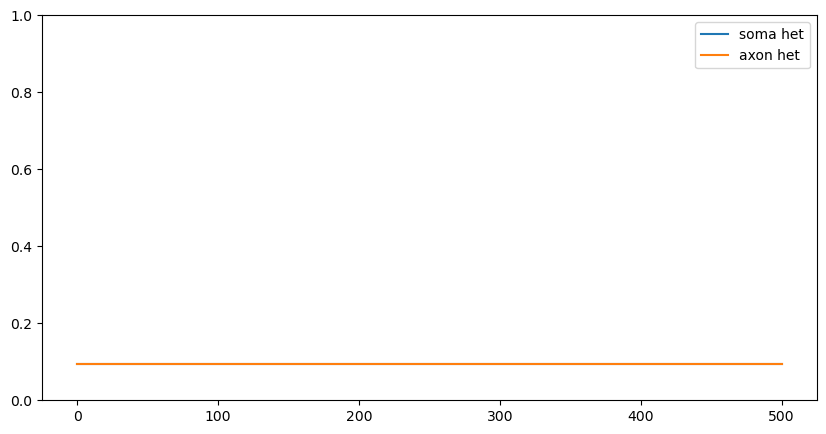

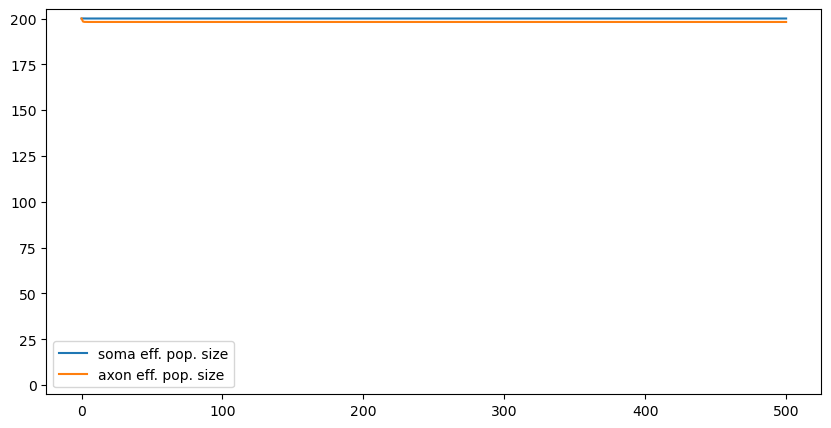

Final counts:
Soma wt: 190.00629417051104
Soma mt: 20.000662544955286
Axon wt: 188.20790007120473
Axon mt: 19.81135790291648
Final effective population size:
soma: 200.01
axon: 198.11


## Pooled results from Gillespie based simulation

In [7]:
REPLICATES = 1000
replicate_results = np.zeros((REPLICATES, 4, TIME_POINTS.size), dtype = np.int64)

print('simulating...')
for i in range(REPLICATES):
    replicate_results[i, :, :] = np.swapaxes(neuron_gill_2c_sim(MU, GAMMA, DELTA, C_B, C_T, NSS_S, NSS_A, TIME_POINTS, start_state), 0, 1)
    print(f"{round(((i+1)/REPLICATES)*100, 2)}% completed  ", end = "\r")
    
results = np.mean(replicate_results, axis = 0)

simulating...


NameError: name 'neuron_gill_2c_sim' is not defined

In [ ]:
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, results[0], label = '# soma wt')
plt.plot(TIME_POINTS, results[1], label = '# soma mt')
plt.plot(TIME_POINTS, results[2], label = '# axon wt')
plt.plot(TIME_POINTS, results[3], label = '# axon mt')
plt.legend()

soma_het = np.mean(replicate_results[:,1,:]/(replicate_results[:,1,:]+replicate_results[:,0,:]), axis = 0)
axon_het = np.mean(replicate_results[:,3,:]/(replicate_results[:,3,:]+replicate_results[:,2,:]), axis = 0)
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_het, label = 'soma het')
plt.plot(TIME_POINTS, axon_het, label = 'axon het')
plt.legend()

soma_count = np.mean(replicate_results[:,1,:]*DELTA+replicate_results[:,0,:], axis = 0)
axon_count = np.mean(replicate_results[:,3,:]*DELTA+replicate_results[:,2,:], axis = 0)
plt.subplots(figsize=(10, 5))
plt.plot(TIME_POINTS, soma_count, label = 'soma eff. pop. size')
plt.plot(TIME_POINTS, axon_count, label = 'axon eff. pop. size')
plt.ylim(min(0, min(soma_count), min(axon_count)) - 5, max(max(soma_count), max(axon_count)) + 5)
plt.legend()

print("Final counts:")
for i, res in enumerate(results[:,-1]): print(f'{VARS[i]}\t{round(res,2)}\t')

print("Final effective population size:")
print("soma:",round(soma_count[-1],2))
print("axon:",round(axon_count[-1],2))